In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import glob
import itertools
import warnings
warnings.filterwarnings("ignore")

def get_variables_8100(file):
    # Colume variables
    SoilFlx = pd.read_csv(file, header=2)
    SoilFlx = SoilFlx.to_numpy() # convert to array
    Timestamps = SoilFlx[:, 0]
    Temp_chamb = SoilFlx[:, 1]
    Labels=SoilFlx[:, 4]
    Flx_linear = SoilFlx[:, 5]
    Flx_expone = SoilFlx[:, 6]
    Flx_CV = SoilFlx[:, 7]
    # Derived variables
    DT = np.array([dt.datetime.strptime(d, '%Y-%m-%d %H:%M:%S') for d in Timestamps])
    Hours= [dt.hour for dt in DT]
    Dates= [dt.date() for dt in DT]
    bNEE = np.array(['_NEE' in lab for lab in Labels])
    bR = np.array(['_R' in lab for lab in Labels])
    return DT, Labels, Flx_linear, Flx_expone, Flx_CV, bNEE, bR

def simple_QC(Flx_CV, Flx_linear, Flx_expone):
    Flx_real= np.empty(len(Flx_linear))
    Flx_real[:]=np.nan
    threshold = 0.1
    
    boo_qc1 = Flx_CV <1.2  #(r2 > 0.99 and) flx_CV <1.2
    for i in range(0, len(Flx_linear)):
        if Flx_CV[i]<1.2:
            Flx_real[i] = Flx_linear[i]
        else:
            if abs((Flx_linear[i]-Flx_expone[i])/Flx_linear[i])<threshold: # and Flx_CV[i]<5.0:
                Flx_real[i] = Flx_linear[i]  
    return Flx_real

Labels_LDEO = ['LC_HL1', 'LC_HL2','LC_HL3','LC_HL4','LC_HL5','LC_HL6',
               'LH_UL1', 'LH_UL2','LH_UL3','LH_UL4','LH_UL5','LH_UL6',
               'LH_SV1', 'LH_SV2']



In [2]:
Datadir='/Users/dandanwei/Desktop/Measurements-2022/SoilFlux/data/cutting/'
file='20220613_LDEO_8100.csv'
DT, Labels, Flx_linear, Flx_expone, Flx_CV, bNEE, bR=get_variables_8100(Datadir+file)
Flx_real = simple_QC(Flx_CV, Flx_linear, Flx_expone)
bC0 = np.array(['_C0' in lab for lab in Labels])
bnoC0 = np.array(['_C0' not in lab for lab in Labels])
# for lab in Labels:
#     print(lab)

print(Labels[bR])
print(Labels[bNEE])

['LH_UL1_R' 'LH_UL2_R' 'LH_UL3_R' 'LH_UL4_R' 'LH_UL5_R' 'LH_UL6_R'
 'LH_UL1_R_C0' 'LH_UL2_R_C0' 'LH_UL3_R_C0' 'LH_UL4_R_C0' 'LH_UL5_R_C0'
 'LH_UL6_R_C0' 'LH_SV2_R' 'LH_SV1_R' 'LH_SV2_R_C0' 'LH_SV1_R_C0'
 'LC_HL1_R' 'LC_HL2_R' 'LC_HL3_R' 'LC_HL4_R' 'LC_HL5_R' 'LC_HL6_R'
 'LC_HL6_R_C0' 'LC_HL5_R_C0' 'LC_HL4_R_C0' 'LC_HL3_R_C0' 'LC_HL2_R_C0'
 'LC_HL1_R_C0']
['LH_UL1_NEE' 'LH_UL2_NEE' 'LH_UL3_NEE' 'LH_UL4_NEE' 'LH_UL5_NEE'
 'LH_UL6_NEE' 'LH_UL1_NEE_C0' 'LH_UL2_NEE_C0' 'LH_UL3_NEE_C0'
 'LH_UL4_NEE_C0' 'LH_UL5_NEE_C0' 'LH_UL6_NEE_C0' 'LH_SV1_NEE' 'LH_SV2_NEE'
 'LH_SV2_NEE_C0' 'LH_SV1_NEE_C0' 'LC_HL5_NEE' 'LC_HL4_NEE' 'LC_HL3_NEE'
 'LC_HL2_NEE' 'LC_HL1_NEE' 'LC_HL1_NEE_C0' 'LC_HL2_NEE_C0' 'LC_HL3_NEE_C0'
 'LC_HL4_NEE_C0' 'LC_HL5_NEE_C0' 'LC_HL6_NEE_C0']


In [3]:
Flx_R_bC = np.empty(len(Labels_LDEO)) # before cutting
Flx_R_C0 = np.empty(len(Labels_LDEO)) # after cutting
Flx_R_bC[:]=np.nan
Flx_R_C0[:]=np.nan

Flx_NEE_bC = np.empty(len(Labels_LDEO)) # before cutting
Flx_NEE_C0 = np.empty(len(Labels_LDEO)) # after cutting
Flx_NEE_bC[:]=np.nan
Flx_NEE_C0[:]=np.nan

ind=0
for label in Labels_LDEO:
    bLabel = np.array([label in lab for lab in Labels])
    bLabR = np.logical_and(bLabel, bR) 
    bLabNEE=np.logical_and(bLabel, bNEE) 
    bRC0 = np.logical_and(bC0, bLabR) 
    bRnotC0 = np.logical_and(bnoC0, bLabR) 
    bNEEC0 = np.logical_and(bC0, bLabNEE) 
    bNEEnotC0 = np.logical_and(bnoC0, bLabNEE) 

    Flx_R_bC[ind] = Flx_real[bRnotC0]  # before cutting
    Flx_R_C0[ind] = Flx_real[bRC0]     # after cutting 
    if Flx_real[bNEEnotC0]:
        Flx_NEE_bC[ind]=Flx_real[bNEEnotC0]
    Flx_NEE_C0[ind]=Flx_real[bNEEC0]
    
    ind+=1
    
Flx_GPP_bC = -Flx_R_bC+Flx_NEE_bC
Flx_GPP_C0 = -Flx_R_C0+Flx_NEE_C0
    

In [4]:
# C1 - one day after cutting
Flx_R_C1 = [10.6168,  13.17671, 12.50616, 10.95659, 12.42367, 13.58899,  9.78459, 12.13047,
 12.46203, 11.29435, 13.52615, 13.0518,  11.92166,  4.67285]
Flx_R_C4 =[14.21078, 14.92982, 13.94752, 13.93455, 12.17153, np.nan, np.nan, 14.39008,
 12.09786, 11.13504, 12.85712, 10.71068, 14.1111,   5.42867]

Flx_NEE_C1=[ 1.64601, -3.69671,  3.06847, -8.16324, -0.91468, -2.5173,   0.88582,  4.46684,
 -2.86775,  2.1389,  -0.10824, -2.96733,  1.57774,  3.02601]
Flx_NEE_C4=[     np.nan, -4.17652, -3.836,   -6.77596, -7.7455,  -4.52429, -0.83526,  2.05371,
 -6.27953, -7.74369, -1.60012, -3.78696,      np.nan , 2.97618]

Flx_GPP_C1=[ -8.97079, -16.87342,  -9.43769, -19.11983, -13.33835, -16.10629,  -8.89877,
  -7.66363, -15.32978 , -9.15545, -13.63439, -16.01913, -10.34392,  -1.64684]
Flx_GPP_C4=[np.nan, -19.10634, -17.78352, -20.71051, -19.91703,  np.nan ,      np.nan,
 -12.33637, -18.37739, -18.87873, -14.45724, -14.49764,       np.nan,  -2.45249]


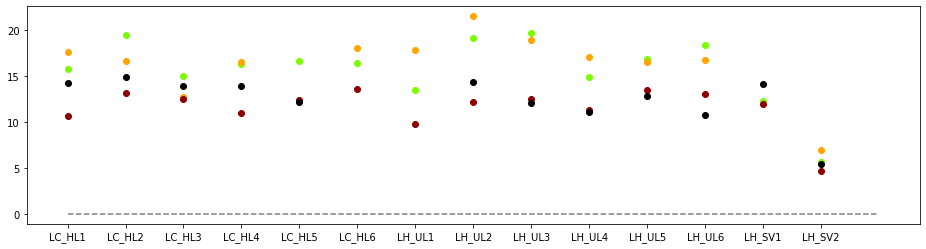

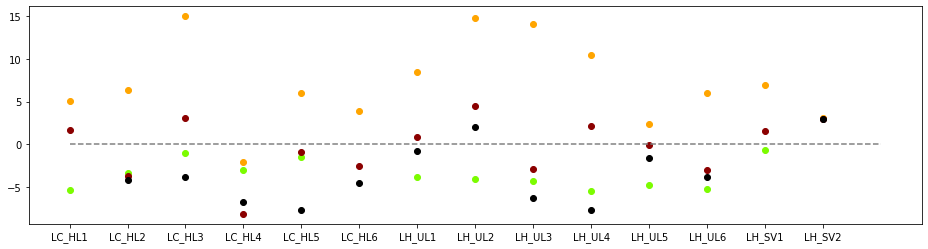

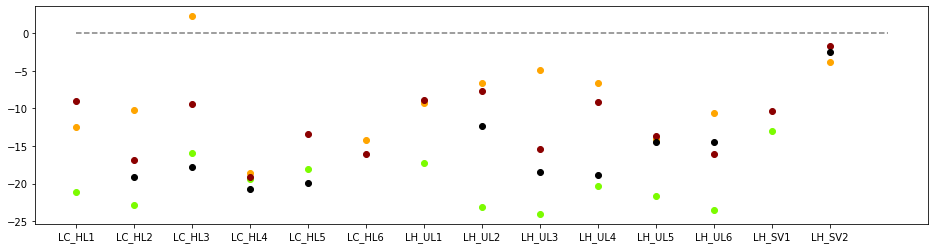

In [5]:
# for lab in Labels_LDEO:
#     print(lab)

plt.figure(figsize=(16, 4))
plt.plot(Labels_LDEO, Flx_R_bC, linestyle='none',marker='o',color='lawngreen')
plt.plot(Labels_LDEO, Flx_R_C0, linestyle='none',marker='o',color='orange') 
plt.plot(Labels_LDEO, Flx_R_C1, linestyle='none',marker='o',color='darkred') 
plt.plot(Labels_LDEO, Flx_R_C4, linestyle='none',marker='o',color='black') 
plt.plot([0, 14], [0, 0], linestyle='--', color='grey')

plt.figure(figsize=(16, 4))
plt.plot(Labels_LDEO, Flx_NEE_bC, linestyle='none',marker='o',color='lawngreen')
plt.plot(Labels_LDEO, Flx_NEE_C0, linestyle='none',marker='o',color='orange') 
plt.plot(Labels_LDEO, Flx_NEE_C1, linestyle='none',marker='o',color='darkred') 
plt.plot(Labels_LDEO, Flx_NEE_C4, linestyle='none',marker='o',color='black') 
plt.plot([0, 14], [0, 0], linestyle='--', color='grey')

plt.figure(figsize=(16, 4))
plt.plot(Labels_LDEO, Flx_GPP_bC, linestyle='none',marker='o',color='lawngreen')
plt.plot(Labels_LDEO, Flx_GPP_C0, linestyle='none',marker='o',color='orange') 
plt.plot(Labels_LDEO, Flx_GPP_C1, linestyle='none',marker='o',color='darkred') 
plt.plot(Labels_LDEO, Flx_GPP_C4, linestyle='none',marker='o',color='black') 
plt.plot([0, 14], [0, 0], linestyle='--', color='grey')

